### exp: eqtl prediction, sign prediction, onehot for machine learning

In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, precision_score, accuracy_score,recall_score, f1_score,roc_auc_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
model_size = ['small','middle','large']
model_list = ['xgboost','lightgbm','random forest','knn','svm']
tissue = 'Heart_Left_Ventricle'
data_path = '../../../../../datasets_embedding/onehot/eqtl_datasets/sign_prediction/' + tissue + '/'
image_path = 'images_seed1030/'
# set seed
seed = 1030
import random
random.seed(seed)
np.random.seed(seed)

#### small model

In [4]:
model = model_size[0]
train_data = pd.read_pickle(data_path + model + '_train.dataset')
valid_data = pd.read_pickle(data_path + model + '_valid.dataset')
test_data = pd.read_pickle(data_path + model + '_test.dataset')
print(train_data.head())

train_data = train_data.sample(frac=1).reset_index(drop=True)
valid_data = valid_data.sample(frac=1).reset_index(drop=True)
test_data = test_data.sample(frac=1).reset_index(drop=True)

train_data = pd.concat([train_data, valid_data]).reset_index(drop=True) # for machine learning, grid search
sample_list = []
y_list = []
for i in range(train_data.shape[0]):
    feature_list = []
    feature_list += train_data['onehot_before'][i].flatten().tolist()
    feature_list += train_data['onehot_after'][i].flatten().tolist()
    sample_list.append(feature_list)
    y_list.append(train_data['label'][i])
X_train = np.array(sample_list)
Y_train = np.array(y_list)
print('X_train shape: ' + str(X_train.shape))
print('Y_train shape: ' + str(Y_train.shape))

sample_list = []
y_list = []
for i in range(test_data.shape[0]):
    feature_list = []
    feature_list += test_data['onehot_before'][i].flatten().tolist()
    feature_list += test_data['onehot_after'][i].flatten().tolist()
    sample_list.append(feature_list)
    y_list.append(test_data['label'][i])
X_test = np.array(sample_list)
Y_test = np.array(y_list)
print('X_test shape: ' + str(X_test.shape))
print('Y_test shape: ' + str(Y_test.shape))

         phenotype_id             variant_id  tss_distance       maf  \
0   ENSG00000236423.5   chr1_3900688_T_C_b38           316  0.084098   
1   ENSG00000090432.6  chr1_20508117_C_A_b38           -44  0.134969   
2   ENSG00000228172.5  chr1_25820023_G_C_b38          -738  0.463303   
3  ENSG00000117640.17  chr1_25820023_G_C_b38          -775  0.463303   
4  ENSG00000000938.12  chr1_27634281_G_A_b38          -996  0.067278   

  ma_samples ma_count  pval_nominal     slope  slope_se  label  \
0         52       55  1.657173e-06  0.342601  0.069935      1   
1         82       88  6.482217e-12  0.276024  0.038419      1   
2        242      303  4.628220e-23  0.513832  0.047313      1   
3        242      303  9.349158e-65  0.530491  0.023360      1   
4         42       44  2.717342e-12  0.523637  0.071486      1   

                                          seq_before  \
0  AGGAGAGCCTCCATGCAGCTCAGAGCCTCCCAAGTGGACCGGGACC...   
1  agcccagatcccgccactgcactccagcctgggcgacacagcaaga...   
2 

In [5]:
print(train_data['label'].unique())

[0 1]


##### model 1: xgboost

In [6]:
# model 1: xgboost
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

cv_params = {'n_estimators': np.linspace(10, 300, 10, dtype=int)} # 
xgb_model = xgb.XGBClassifier(seed=seed)

gs = GridSearchCV(xgb_model, cv_params, refit=True, cv=5, scoring='roc_auc')
gs.fit(X_train,Y_train)
n_estimators = gs.best_params_['n_estimators']
print(gs.best_params_)

cv_params = {'max_depth': np.linspace(1, 10, 10, dtype=int)} # 
xgb_model = xgb.XGBClassifier(seed=seed,n_estimators=n_estimators)
gs = GridSearchCV(xgb_model, cv_params, refit=True, cv=5)
gs.fit(X_train,Y_train)
max_depth = gs.best_params_['max_depth']
print(gs.best_params_)

{'n_estimators': 10}
{'max_depth': 5}


accuracy:0.42105263157894735
precision:0.5
recall:0.7272727272727273
f1-score:0.5925925925925926


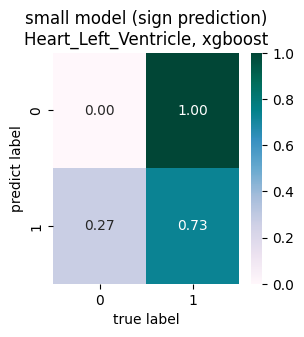

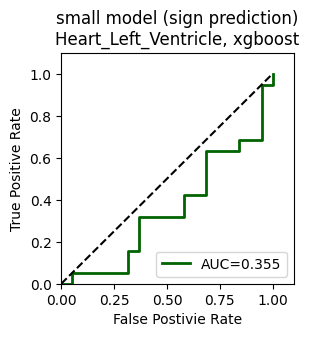

In [7]:
ml_model = model_list[0]
clf_xgb = xgb.XGBClassifier(n_estimators=n_estimators, max_depth=max_depth) # from grid search
clf_xgb.fit(X_train,Y_train)

y_score = clf_xgb.predict(X_test)                                   
y_score_pro = clf_xgb.predict_proba(X_test) 
y_one_hot = to_categorical(Y_test)
y_score_one_hot = to_categorical(y_score)

obj1 = confusion_matrix(Y_test, y_score)
print('accuracy:{}'.format(accuracy_score(Y_test, y_score)))
print('precision:{}'.format(precision_score(Y_test, y_score)))
print('recall:{}'.format(recall_score(Y_test, y_score)))
print('f1-score:{}'.format(f1_score(Y_test, y_score)))

# update confusion matrix
sum_all1 = obj1[0][0] + obj1[0][1]
sum_all2 = obj1[1][0] + obj1[1][1]
new_obj = np.array(
    [
        [float(obj1[0][0])/sum_all1, float(obj1[0][1])/sum_all1],
        [float(obj1[1][0])/sum_all2, float(obj1[1][1])/sum_all2]
    ]
)
ax = plt.subplots(figsize=(3,3))
sns.heatmap(new_obj, fmt='.2f', cmap='PuBuGn', annot=True)
plt.xlabel("true label")
plt.ylabel("predict label")
plt.title('small model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.savefig(image_path + 'cm-small-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
auc_ = auc(fpr, tpr)
#print("AUC : ", auc_)
ax = plt.subplots(figsize=(3,3))
plt.title('small model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.plot(fpr, tpr, linewidth = 2,label='AUC=%.3f' % auc_,color='#006400')
plt.plot([0,1],[0,1], 'k--')
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig(image_path + 'auc-small-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 2:lightgbm

In [8]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

cv_params = {'max_depth': np.linspace(1, 50, 10, dtype=int)} # 
gbm = lgb.LGBMClassifier(seed=seed,verbose=-1)
gsearch = GridSearchCV(gbm, param_grid=cv_params, cv=5, scoring='roc_auc')
gsearch.fit(X_train, Y_train)
max_depth = gsearch.best_params_['max_depth']
print(gsearch.best_params_)

cv_params = {'num_leaves': np.linspace(2, 50, 5, dtype=int)} # 
gbm = lgb.LGBMClassifier(seed=seed,max_depth=max_depth,verbose=-1)
gsearch = GridSearchCV(gbm, param_grid=cv_params, cv=5, scoring='roc_auc')
gsearch.fit(X_train, Y_train)
num_leaves = gsearch.best_params_['num_leaves']
print(gsearch.best_params_)

{'max_depth': 6}
{'num_leaves': 14}


[LightGBM] [Info] Number of positive: 130, number of negative: 92
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.243043 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 32016
[LightGBM] [Info] Number of data points in the train set: 222, number of used features: 16008
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.585586 -> initscore=0.345746
[LightGBM] [Info] Start training from score 0.345746
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

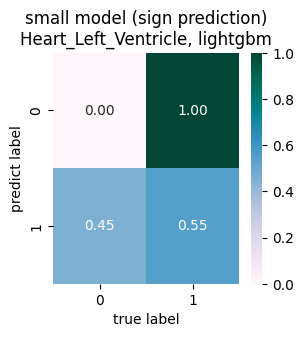

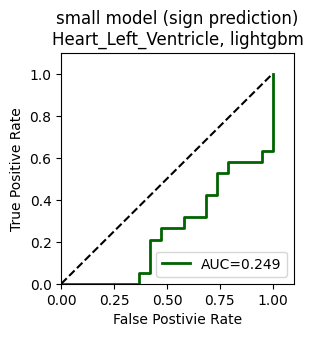

In [9]:
ml_model = model_list[1]
clf_lgb = lgb.LGBMClassifier(max_depth=max_depth, num_leaves=num_leaves)
clf_lgb.fit(X_train,Y_train)

y_score = clf_lgb.predict(X_test)                                   
y_score_pro = clf_lgb.predict_proba(X_test) 
y_one_hot = to_categorical(Y_test)
y_score_one_hot = to_categorical(y_score)

obj1 = confusion_matrix(Y_test, y_score)
print('accuracy:{}'.format(accuracy_score(Y_test, y_score)))
print('precision:{}'.format(precision_score(Y_test, y_score)))
print('recall:{}'.format(recall_score(Y_test, y_score)))
print('f1-score:{}'.format(f1_score(Y_test, y_score)))

# update confusion matrix
sum_all1 = obj1[0][0] + obj1[0][1]
sum_all2 = obj1[1][0] + obj1[1][1]
new_obj = np.array(
    [
        [float(obj1[0][0])/sum_all1, float(obj1[0][1])/sum_all1],
        [float(obj1[1][0])/sum_all2, float(obj1[1][1])/sum_all2]
    ]
)
ax = plt.subplots(figsize=(3,3))
sns.heatmap(new_obj, fmt='.2f', cmap='PuBuGn', annot=True)
plt.xlabel("true label")
plt.ylabel("predict label")
plt.title('small model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.savefig(image_path + 'cm-small-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
auc_ = auc(fpr, tpr)
#print("AUC : ", auc_)
ax = plt.subplots(figsize=(3,3))
plt.title('small model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.plot(fpr, tpr, linewidth = 2,label='AUC=%.3f' % auc_,color='#006400')
plt.plot([0,1],[0,1], 'k--')
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig(image_path + 'auc-small-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 3: random forest

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

cv_params = {'n_estimators': np.linspace(10, 200, 10, dtype=int)} 
rfModel = RandomForestClassifier(random_state = random.seed(seed))
grid = GridSearchCV(
    rfModel,cv_params,cv = 5,return_train_score = True, scoring='roc_auc')
grid.fit(X_train, Y_train)
n_estimators = grid.best_params_['n_estimators']
print(grid.best_params_)

cv_params = {'max_depth': np.linspace(1, 10, 10, dtype=int)} 
rfModel = RandomForestClassifier(random_state = random.seed(seed),n_estimators=n_estimators)
grid = GridSearchCV(
    rfModel,cv_params,cv = 5,return_train_score = True, scoring='roc_auc')
grid.fit(X_train, Y_train)
max_depth=grid.best_params_['max_depth']
print(grid.best_params_)

{'n_estimators': 31}
{'max_depth': 9}


accuracy:0.5263157894736842
precision:0.5714285714285714
recall:0.7272727272727273
f1-score:0.64


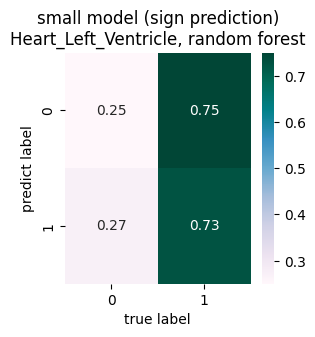

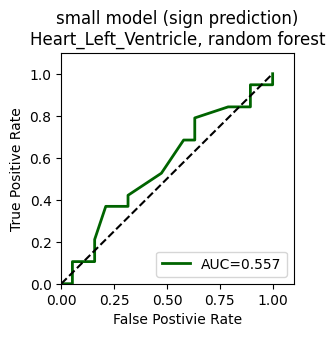

In [11]:
ml_model = model_list[2]
clf_rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth)
clf_rf.fit(X_train,Y_train)

y_score = clf_rf.predict(X_test)                                   
y_score_pro = clf_rf.predict_proba(X_test) 
y_one_hot = to_categorical(Y_test)
y_score_one_hot = to_categorical(y_score)

obj1 = confusion_matrix(Y_test, y_score)
print('accuracy:{}'.format(accuracy_score(Y_test, y_score)))
print('precision:{}'.format(precision_score(Y_test, y_score)))
print('recall:{}'.format(recall_score(Y_test, y_score)))
print('f1-score:{}'.format(f1_score(Y_test, y_score)))

# update confusion matrix
sum_all1 = obj1[0][0] + obj1[0][1]
sum_all2 = obj1[1][0] + obj1[1][1]
new_obj = np.array(
    [
        [float(obj1[0][0])/sum_all1, float(obj1[0][1])/sum_all1],
        [float(obj1[1][0])/sum_all2, float(obj1[1][1])/sum_all2]
    ]
)
ax = plt.subplots(figsize=(3,3))
sns.heatmap(new_obj, fmt='.2f', cmap='PuBuGn', annot=True)
plt.xlabel("true label")
plt.ylabel("predict label")
plt.title('small model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.savefig(image_path + 'cm-small-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
auc_ = auc(fpr, tpr)
#print("AUC : ", auc_)
ax = plt.subplots(figsize=(3,3))
plt.title('small model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.plot(fpr, tpr, linewidth = 2,label='AUC=%.3f' % auc_,color='#006400')
plt.plot([0,1],[0,1], 'k--')
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig(image_path + 'auc-small-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 4: knn

In [12]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

paramGride = {'n_neighbors': np.linspace(100, 300, 10, dtype=int)} 

knnModel = KNeighborsClassifier()
grid = GridSearchCV(
    knnModel,paramGride,cv = 5,return_train_score = True, scoring='roc_auc')
grid = grid.fit(X_train,Y_train)
grid.best_params_

{'n_neighbors': 166}

accuracy:0.5789473684210527
precision:0.5789473684210527
recall:1.0
f1-score:0.7333333333333333


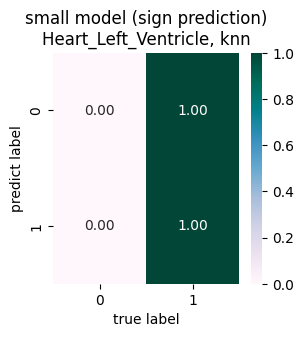

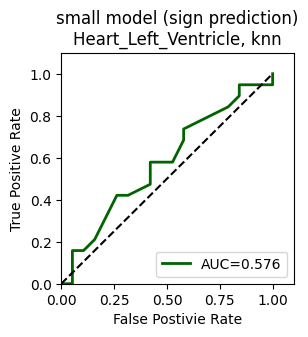

In [13]:
ml_model = model_list[3]
clf_knn = KNeighborsClassifier(n_neighbors = grid.best_params_['n_neighbors'])
clf_knn.fit(X_train,Y_train)

y_score = clf_knn.predict(X_test)                                   
y_score_pro = clf_knn.predict_proba(X_test) 
y_one_hot = to_categorical(Y_test)
y_score_one_hot = to_categorical(y_score)

obj1 = confusion_matrix(Y_test, y_score)
print('accuracy:{}'.format(accuracy_score(Y_test, y_score)))
print('precision:{}'.format(precision_score(Y_test, y_score)))
print('recall:{}'.format(recall_score(Y_test, y_score)))
print('f1-score:{}'.format(f1_score(Y_test, y_score)))

# update confusion matrix
sum_all1 = obj1[0][0] + obj1[0][1]
sum_all2 = obj1[1][0] + obj1[1][1]
new_obj = np.array(
    [
        [float(obj1[0][0])/sum_all1, float(obj1[0][1])/sum_all1],
        [float(obj1[1][0])/sum_all2, float(obj1[1][1])/sum_all2]
    ]
)
ax = plt.subplots(figsize=(3,3))
sns.heatmap(new_obj, fmt='.2f', cmap='PuBuGn', annot=True)
plt.xlabel("true label")
plt.ylabel("predict label")
plt.title('small model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.savefig(image_path + 'cm-small-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
auc_ = auc(fpr, tpr)
#print("AUC : ", auc_)
ax = plt.subplots(figsize=(3,3))
plt.title('small model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.plot(fpr, tpr, linewidth = 2,label='AUC=%.3f' % auc_,color='#006400')
plt.plot([0,1],[0,1], 'k--')
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig(image_path + 'auc-small-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 5: svm

In [14]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

cv_params = {'gamma': [1e-4,1e-3,1e-2,1e-1,1,10,100,1000]} 
svmModel = SVC()
grid = GridSearchCV(
    svmModel,cv_params,cv = 5,return_train_score = True, scoring='roc_auc')
grid = grid.fit(X_train,Y_train)
gamma = grid.best_params_['gamma']
print(grid.best_params_)

cv_params = {'C': [1e-4,1e-3,1e-2,1e-1,1,10,100,1000]} 
svmModel = SVC(gamma=gamma)
grid = GridSearchCV(
    svmModel,cv_params,cv = 5,return_train_score = True, scoring='roc_auc')
grid = grid.fit(X_train,Y_train)
C = grid.best_params_['C']
print(grid.best_params_)

{'gamma': 0.1}
{'C': 1}


accuracy:0.5789473684210527
precision:0.5789473684210527
recall:1.0
f1-score:0.7333333333333333


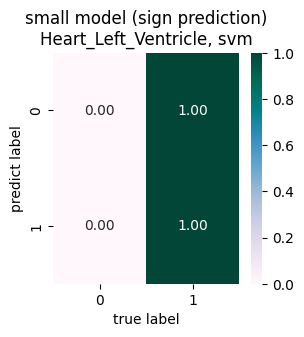

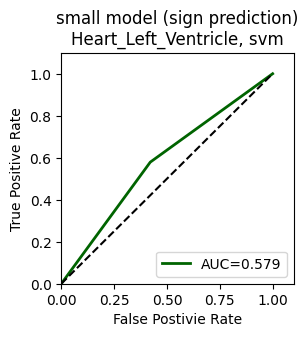

In [15]:
ml_model = model_list[4]
clf_svm = SVC(probability = True, gamma = gamma, C = C)
clf_svm.fit(X_train,Y_train)

y_score = clf_svm.predict(X_test)                                   
y_score_pro = clf_svm.predict_proba(X_test) 
y_one_hot = to_categorical(Y_test)
y_score_one_hot = to_categorical(y_score)

obj1 = confusion_matrix(Y_test, y_score)
print('accuracy:{}'.format(accuracy_score(Y_test, y_score)))
print('precision:{}'.format(precision_score(Y_test, y_score)))
print('recall:{}'.format(recall_score(Y_test, y_score)))
print('f1-score:{}'.format(f1_score(Y_test, y_score)))

# update confusion matrix
sum_all1 = obj1[0][0] + obj1[0][1]
sum_all2 = obj1[1][0] + obj1[1][1]
new_obj = np.array(
    [
        [float(obj1[0][0])/sum_all1, float(obj1[0][1])/sum_all1],
        [float(obj1[1][0])/sum_all2, float(obj1[1][1])/sum_all2]
    ]
)
ax = plt.subplots(figsize=(3,3))
sns.heatmap(new_obj, fmt='.2f', cmap='PuBuGn', annot=True)
plt.xlabel("true label")
plt.ylabel("predict label")
plt.title('small model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.savefig(image_path + 'cm-small-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
auc_ = auc(fpr, tpr)
#print("AUC : ", auc_)
ax = plt.subplots(figsize=(3,3))
plt.title('small model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.plot(fpr, tpr, linewidth = 2,label='AUC=%.3f' % auc_,color='#006400')
plt.plot([0,1],[0,1], 'k--')
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig(image_path + 'auc-small-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

#### middle model

In [16]:
model = model_size[1]
train_data = pd.read_pickle(data_path + model + '_train.dataset')
valid_data = pd.read_pickle(data_path + model + '_valid.dataset')
test_data = pd.read_pickle(data_path + model + '_test.dataset')
print(train_data.head())

train_data = train_data.sample(frac=1).reset_index(drop=True)
valid_data = valid_data.sample(frac=1).reset_index(drop=True)
test_data = test_data.sample(frac=1).reset_index(drop=True)

train_data = pd.concat([train_data, valid_data]).reset_index(drop=True) # for machine learning, grid search
sample_list = []
y_list = []
for i in range(train_data.shape[0]):
    feature_list = []
    feature_list += train_data['onehot_before'][i].flatten().tolist()
    feature_list += train_data['onehot_after'][i].flatten().tolist()
    sample_list.append(feature_list)
    y_list.append(train_data['label'][i])
X_train = np.array(sample_list)
Y_train = np.array(y_list)
print('X_train shape: ' + str(X_train.shape))
print('Y_train shape: ' + str(Y_train.shape))

sample_list = []
y_list = []
for i in range(test_data.shape[0]):
    feature_list = []
    feature_list += test_data['onehot_before'][i].flatten().tolist()
    feature_list += test_data['onehot_after'][i].flatten().tolist()
    sample_list.append(feature_list)
    y_list.append(test_data['label'][i])
X_test = np.array(sample_list)
Y_test = np.array(y_list)
print('X_test shape: ' + str(X_test.shape))
print('Y_test shape: ' + str(Y_test.shape))

         phenotype_id             variant_id  tss_distance       maf  \
0  ENSG00000198912.10   chr1_3891607_T_C_b38         -8678  0.237003   
1   ENSG00000158292.6   chr1_6262459_G_C_b38          1484  0.097859   
2  ENSG00000117122.13  chr1_16988930_G_A_b38          8095  0.422018   
3  ENSG00000183431.11  chr1_37997832_C_T_b38          6911  0.397554   
4  ENSG00000162604.12  chr1_61723869_T_C_b38         -1554  0.226300   

  ma_samples ma_count  pval_nominal     slope  slope_se  label  \
0        134      155  1.254417e-46  0.807717  0.046026      1   
1         61       64  4.483494e-43  1.232429  0.074424      1   
2        216      276  4.477894e-16  0.309680  0.035791      1   
3        201      260  8.121680e-28  0.426557  0.034783      1   
4        131      148  3.871276e-08  0.233419  0.041253      1   

                                          seq_before  \
0  AACAAAAGAAATTAACAGCAAGCGCGGGGTGGATGTTCAAAAAAAC...   
1  TATCCAGACAGGACCTCGGTCTGCAGGAGCCCCCAGGGCAGCTTGC...   
2 

##### model 1: xgboost

In [17]:
# model 1: xgboost
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

cv_params = {'n_estimators': np.linspace(10, 300, 10, dtype=int)} # 
xgb_model = xgb.XGBClassifier(seed=seed)
# https://scikit-learn.org/stable/modules/model_evaluation.html
gs = GridSearchCV(xgb_model, cv_params, refit=True, cv=5, scoring='roc_auc')
gs.fit(X_train,Y_train)
n_estimators = gs.best_params_['n_estimators']
print(gs.best_params_)

cv_params = {'max_depth': np.linspace(1, 10, 10, dtype=int)} # 
xgb_model = xgb.XGBClassifier(seed=seed,n_estimators=n_estimators)
gs = GridSearchCV(xgb_model, cv_params, refit=True, cv=5, scoring='roc_auc')
gs.fit(X_train,Y_train)
max_depth = gs.best_params_['max_depth']
print(gs.best_params_)

{'n_estimators': 300}
{'max_depth': 1}


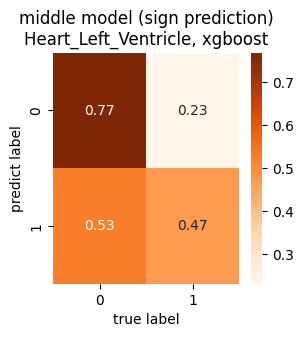

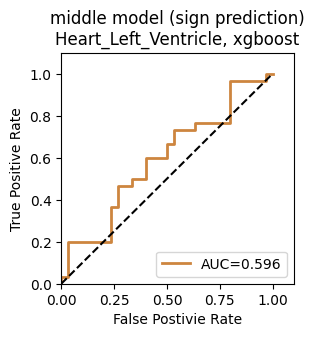

In [18]:
ml_model = model_list[0]
clf_xgb = xgb.XGBClassifier(n_estimators=n_estimators, max_depth=max_depth) # from grid search
clf_xgb.fit(X_train,Y_train)

y_score = clf_xgb.predict(X_test)                                   
y_score_pro = clf_xgb.predict_proba(X_test) 
y_one_hot = to_categorical(Y_test)
y_score_one_hot = to_categorical(y_score)

obj1 = confusion_matrix(Y_test, y_score)
print('accuracy:{}'.format(accuracy_score(Y_test, y_score)))
print('precision:{}'.format(precision_score(Y_test, y_score)))
print('recall:{}'.format(recall_score(Y_test, y_score)))
print('f1-score:{}'.format(f1_score(Y_test, y_score)))

# update confusion matrix
sum_all1 = obj1[0][0] + obj1[0][1]
sum_all2 = obj1[1][0] + obj1[1][1]
new_obj = np.array(
    [
        [float(obj1[0][0])/sum_all1, float(obj1[0][1])/sum_all1],
        [float(obj1[1][0])/sum_all2, float(obj1[1][1])/sum_all2]
    ]
)
ax = plt.subplots(figsize=(3,3))
sns.heatmap(new_obj, fmt='.2f', cmap='Oranges', annot=True)
plt.xlabel("true label")
plt.ylabel("predict label")
plt.title('middle model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.savefig(image_path + 'cm-middle-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
auc_ = auc(fpr, tpr)
#print("AUC : ", auc_)
ax = plt.subplots(figsize=(3,3))
plt.title('middle model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.plot(fpr, tpr, linewidth = 2,label='AUC=%.3f' % auc_,color='#CD853F')
plt.plot([0,1],[0,1], 'k--')
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig(image_path + 'auc-middle-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 2:lightgbm

In [19]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

cv_params = {'max_depth': np.linspace(1, 50, 10, dtype=int)} # 
gbm = lgb.LGBMClassifier(seed=seed,verbose=-1)
gsearch = GridSearchCV(gbm, param_grid=cv_params, cv=5, scoring='roc_auc')
gsearch.fit(X_train, Y_train)
max_depth = gsearch.best_params_['max_depth']
print(gsearch.best_params_)

cv_params = {'num_leaves': np.linspace(2, 50, 5, dtype=int)} # 
gbm = lgb.LGBMClassifier(seed=seed,max_depth=max_depth,verbose=-1)
gsearch = GridSearchCV(gbm, param_grid=cv_params, cv=5, scoring='roc_auc')
gsearch.fit(X_train, Y_train)
num_leaves = gsearch.best_params_['num_leaves']
print(gsearch.best_params_)

{'max_depth': 1}
{'num_leaves': 2}


[LightGBM] [Info] Number of positive: 109, number of negative: 112
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 3.214715 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 320016
[LightGBM] [Info] Number of data points in the train set: 221, number of used features: 160008
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493213 -> initscore=-0.027151
[LightGBM] [Info] Start training from score -0.027151
accuracy:0.5
precision:0.625
recall:0.29411764705882354
f1-score:0.4


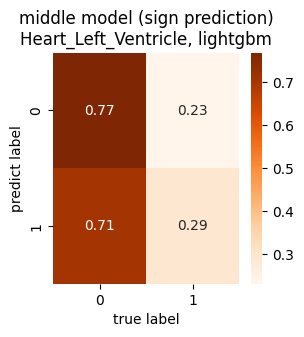

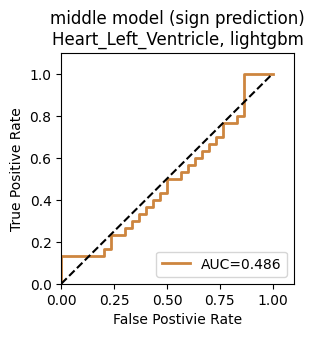

In [20]:
ml_model = model_list[1]
clf_lgb = lgb.LGBMClassifier(max_depth=max_depth, num_leaves=num_leaves)
clf_lgb.fit(X_train,Y_train)

y_score = clf_lgb.predict(X_test)                                   
y_score_pro = clf_lgb.predict_proba(X_test) 
y_one_hot = to_categorical(Y_test)
y_score_one_hot = to_categorical(y_score)

obj1 = confusion_matrix(Y_test, y_score)
print('accuracy:{}'.format(accuracy_score(Y_test, y_score)))
print('precision:{}'.format(precision_score(Y_test, y_score)))
print('recall:{}'.format(recall_score(Y_test, y_score)))
print('f1-score:{}'.format(f1_score(Y_test, y_score)))

# update confusion matrix
sum_all1 = obj1[0][0] + obj1[0][1]
sum_all2 = obj1[1][0] + obj1[1][1]
new_obj = np.array(
    [
        [float(obj1[0][0])/sum_all1, float(obj1[0][1])/sum_all1],
        [float(obj1[1][0])/sum_all2, float(obj1[1][1])/sum_all2]
    ]
)
ax = plt.subplots(figsize=(3,3))
sns.heatmap(new_obj, fmt='.2f', cmap='Oranges', annot=True)
plt.xlabel("true label")
plt.ylabel("predict label")
plt.title('middle model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.savefig(image_path + 'cm-middle-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
auc_ = auc(fpr, tpr)
#print("AUC : ", auc_)
ax = plt.subplots(figsize=(3,3))
plt.title('middle model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.plot(fpr, tpr, linewidth = 2,label='AUC=%.3f' % auc_,color='#CD853F')
plt.plot([0,1],[0,1], 'k--')
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig(image_path + 'auc-middle-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 3: random forest

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

cv_params = {'n_estimators': np.linspace(10, 200, 10, dtype=int)} 
rfModel = RandomForestClassifier(random_state = random.seed(seed))
grid = GridSearchCV(
    rfModel,cv_params,cv = 5,return_train_score = True, scoring='roc_auc')
grid.fit(X_train, Y_train)
n_estimators = grid.best_params_['n_estimators']
print(grid.best_params_)

cv_params = {'max_depth': np.linspace(1, 10, 10, dtype=int)} 
rfModel = RandomForestClassifier(random_state = random.seed(seed),n_estimators=n_estimators)
grid = GridSearchCV(
    rfModel,cv_params,cv = 5,return_train_score = True, scoring='roc_auc')
grid.fit(X_train, Y_train)
max_depth=grid.best_params_['max_depth']
print(grid.best_params_)

{'n_estimators': 115}
{'max_depth': 6}


accuracy:0.5
precision:0.5833333333333334
recall:0.4117647058823529
f1-score:0.4827586206896552


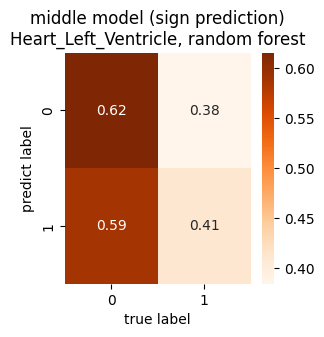

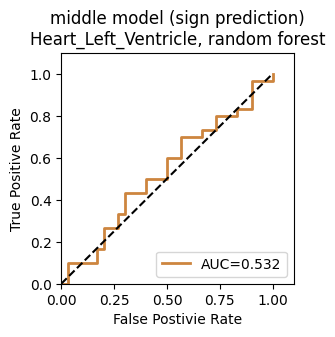

In [22]:
ml_model = model_list[2]
clf_rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth)
clf_rf.fit(X_train,Y_train)

y_score = clf_rf.predict(X_test)                                   
y_score_pro = clf_rf.predict_proba(X_test) 
y_one_hot = to_categorical(Y_test)
y_score_one_hot = to_categorical(y_score)

obj1 = confusion_matrix(Y_test, y_score)
print('accuracy:{}'.format(accuracy_score(Y_test, y_score)))
print('precision:{}'.format(precision_score(Y_test, y_score)))
print('recall:{}'.format(recall_score(Y_test, y_score)))
print('f1-score:{}'.format(f1_score(Y_test, y_score)))

# update confusion matrix
sum_all1 = obj1[0][0] + obj1[0][1]
sum_all2 = obj1[1][0] + obj1[1][1]
new_obj = np.array(
    [
        [float(obj1[0][0])/sum_all1, float(obj1[0][1])/sum_all1],
        [float(obj1[1][0])/sum_all2, float(obj1[1][1])/sum_all2]
    ]
)
ax = plt.subplots(figsize=(3,3))
sns.heatmap(new_obj, fmt='.2f', cmap='Oranges', annot=True)
plt.xlabel("true label")
plt.ylabel("predict label")
plt.title('middle model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.savefig(image_path + 'cm-middle-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
auc_ = auc(fpr, tpr)
#print("AUC : ", auc_)
ax = plt.subplots(figsize=(3,3))
plt.title('middle model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.plot(fpr, tpr, linewidth = 2,label='AUC=%.3f' % auc_,color='#CD853F')
plt.plot([0,1],[0,1], 'k--')
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig(image_path + 'auc-middle-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 4: knn

In [23]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

paramGride = {'n_neighbors': np.linspace(100, 300, 10, dtype=int)} 

knnModel = KNeighborsClassifier()
grid = GridSearchCV(
    knnModel,paramGride,cv = 5,return_train_score = True, scoring='roc_auc')
grid = grid.fit(X_train,Y_train)
grid.best_params_

{'n_neighbors': 144}

accuracy:0.43333333333333335
precision:0.5
recall:0.11764705882352941
f1-score:0.19047619047619047


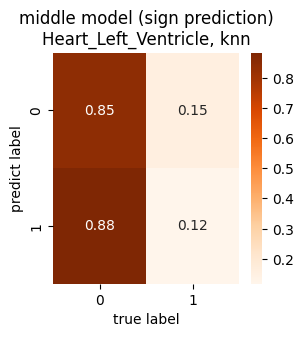

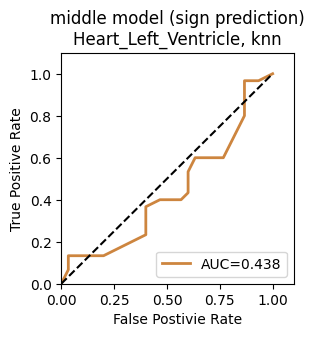

In [24]:
ml_model = model_list[3]
clf_knn = KNeighborsClassifier(n_neighbors = grid.best_params_['n_neighbors'])
clf_knn.fit(X_train,Y_train)

y_score = clf_knn.predict(X_test)                                   
y_score_pro = clf_knn.predict_proba(X_test) 
y_one_hot = to_categorical(Y_test)
y_score_one_hot = to_categorical(y_score)

obj1 = confusion_matrix(Y_test, y_score)
print('accuracy:{}'.format(accuracy_score(Y_test, y_score)))
print('precision:{}'.format(precision_score(Y_test, y_score)))
print('recall:{}'.format(recall_score(Y_test, y_score)))
print('f1-score:{}'.format(f1_score(Y_test, y_score)))

# update confusion matrix
sum_all1 = obj1[0][0] + obj1[0][1]
sum_all2 = obj1[1][0] + obj1[1][1]
new_obj = np.array(
    [
        [float(obj1[0][0])/sum_all1, float(obj1[0][1])/sum_all1],
        [float(obj1[1][0])/sum_all2, float(obj1[1][1])/sum_all2]
    ]
)
ax = plt.subplots(figsize=(3,3))
sns.heatmap(new_obj, fmt='.2f', cmap='Oranges', annot=True)
plt.xlabel("true label")
plt.ylabel("predict label")
plt.title('middle model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.savefig(image_path + 'cm-middle-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
auc_ = auc(fpr, tpr)
#print("AUC : ", auc_)
ax = plt.subplots(figsize=(3,3))
plt.title('middle model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.plot(fpr, tpr, linewidth = 2,label='AUC=%.3f' % auc_,color='#CD853F')
plt.plot([0,1],[0,1], 'k--')
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig(image_path + 'auc-middle-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 5: svm

In [25]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

cv_params = {'gamma': [1e-4,1e-3,1e-2,1e-1,1,10,100,1000]} 
svmModel = SVC()
grid = GridSearchCV(
    svmModel,cv_params,cv = 5,return_train_score = True, scoring='roc_auc')
grid = grid.fit(X_train,Y_train)
gamma = grid.best_params_['gamma']
print(grid.best_params_)

cv_params = {'C': [1e-4,1e-3,1e-2,1e-1,1,10,100,1000]} 
svmModel = SVC(gamma=gamma)
grid = GridSearchCV(
    svmModel,cv_params,cv = 5,return_train_score = True, scoring='roc_auc')
grid = grid.fit(X_train,Y_train)
C = grid.best_params_['C']
print(grid.best_params_)

{'gamma': 0.01}
{'C': 1}


accuracy:0.43333333333333335
precision:0.0
recall:0.0
f1-score:0.0


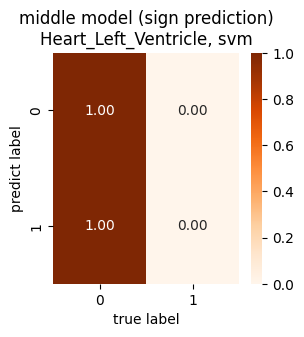

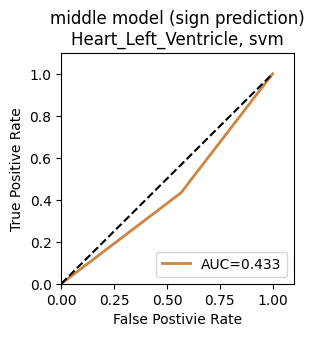

In [26]:
ml_model = model_list[4]
clf_svm = SVC(probability = True, gamma = gamma, C = C)
clf_svm.fit(X_train,Y_train)

y_score = clf_svm.predict(X_test)                                   
y_score_pro = clf_svm.predict_proba(X_test) 
y_one_hot = to_categorical(Y_test)
y_score_one_hot = to_categorical(y_score)

obj1 = confusion_matrix(Y_test, y_score)
print('accuracy:{}'.format(accuracy_score(Y_test, y_score)))
print('precision:{}'.format(precision_score(Y_test, y_score)))
print('recall:{}'.format(recall_score(Y_test, y_score)))
print('f1-score:{}'.format(f1_score(Y_test, y_score)))

# update confusion matrix
sum_all1 = obj1[0][0] + obj1[0][1]
sum_all2 = obj1[1][0] + obj1[1][1]
new_obj = np.array(
    [
        [float(obj1[0][0])/sum_all1, float(obj1[0][1])/sum_all1],
        [float(obj1[1][0])/sum_all2, float(obj1[1][1])/sum_all2]
    ]
)
ax = plt.subplots(figsize=(3,3))
sns.heatmap(new_obj, fmt='.2f', cmap='Oranges', annot=True)
plt.xlabel("true label")
plt.ylabel("predict label")
plt.title('middle model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.savefig(image_path + 'cm-middle-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
auc_ = auc(fpr, tpr)
#print("AUC : ", auc_)
ax = plt.subplots(figsize=(3,3))
plt.title('middle model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.plot(fpr, tpr, linewidth = 2,label='AUC=%.3f' % auc_,color='#CD853F')
plt.plot([0,1],[0,1], 'k--')
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig(image_path + 'auc-middle-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

#### large model

In [4]:
model = model_size[2]
train_data = pd.read_pickle(data_path + model + '_train.dataset')
valid_data = pd.read_pickle(data_path + model + '_valid.dataset')
test_data = pd.read_pickle(data_path + model + '_test.dataset')
print(train_data.head())

train_data = train_data.sample(frac=1).reset_index(drop=True)
valid_data = valid_data.sample(frac=1).reset_index(drop=True)
test_data = test_data.sample(frac=1).reset_index(drop=True)

train_data = pd.concat([train_data, valid_data]).reset_index(drop=True) # for machine learning, grid search
sample_list = []
y_list = []
for i in range(train_data.shape[0]):
    feature_list = []
    feature_list += train_data['onehot_before'][i].flatten().tolist()
    feature_list += train_data['onehot_after'][i].flatten().tolist()
    sample_list.append(feature_list)
    y_list.append(train_data['label'][i])
X_train = np.array(sample_list)
Y_train = np.array(y_list)
print('X_train shape: ' + str(X_train.shape))
print('Y_train shape: ' + str(Y_train.shape))

sample_list = []
y_list = []
for i in range(test_data.shape[0]):
    feature_list = []
    feature_list += test_data['onehot_before'][i].flatten().tolist()
    feature_list += test_data['onehot_after'][i].flatten().tolist()
    sample_list.append(feature_list)
    y_list.append(test_data['label'][i])
X_test = np.array(sample_list)
Y_test = np.array(y_list)
print('X_test shape: ' + str(X_test.shape))
print('Y_test shape: ' + str(Y_test.shape))

         phenotype_id             variant_id  tss_distance       maf  \
0  ENSG00000198912.10   chr1_3913050_A_G_b38         12765  0.238532   
1  ENSG00000219481.10  chr1_16577626_T_G_b38        -35936  0.470948   
2  ENSG00000058453.16  chr1_16907772_T_A_b38        -14178  0.223242   
3   ENSG00000204219.9  chr1_23383982_C_T_b38        -40758  0.478593   
4  ENSG00000186501.14  chr1_27335461_C_T_b38         13316  0.012232   

  ma_samples ma_count  pval_nominal     slope  slope_se  label  \
0        135      156  1.310923e-45  0.803954  0.046565      1   
1        249      308  6.291642e-12  0.370057  0.051472      1   
2        136      146  1.943628e-24  0.406539  0.036065      1   
3        229      313  2.416720e-17  0.215370  0.023740      1   
4          8        8  1.017953e-14  1.098259  0.134080      1   

                                          seq_before  \
0  ggaagcagtatgtgggatgtgaactgaagtgcacctggaaatcctc...   
1  tatgcgctagggcacctgggggccggcagagccgttcccctacGca...   
2 

##### model 1: xgboost

In [5]:
# model 1: xgboost
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

cv_params = {'n_estimators': np.linspace(10, 300, 10, dtype=int)} # 
xgb_model = xgb.XGBClassifier(seed=seed)
# https://scikit-learn.org/stable/modules/model_evaluation.html
gs = GridSearchCV(xgb_model, cv_params, refit=True, cv=5, scoring='roc_auc')
gs.fit(X_train,Y_train)
n_estimators = gs.best_params_['n_estimators']
print(gs.best_params_)

cv_params = {'max_depth': np.linspace(1, 10, 10, dtype=int)} # 
xgb_model = xgb.XGBClassifier(seed=seed,n_estimators=n_estimators)
gs = GridSearchCV(xgb_model, cv_params, refit=True, cv=5, scoring='roc_auc')
gs.fit(X_train,Y_train)
max_depth = gs.best_params_['max_depth']
print(gs.best_params_)

{'n_estimators': 235}
{'max_depth': 2}


accuracy:0.45
precision:0.36363636363636365
recall:0.5
f1-score:0.4210526315789474


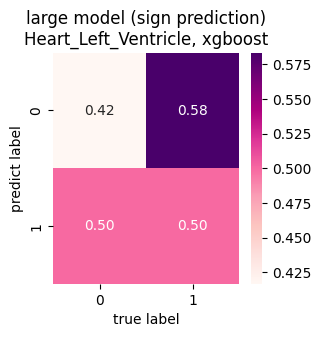

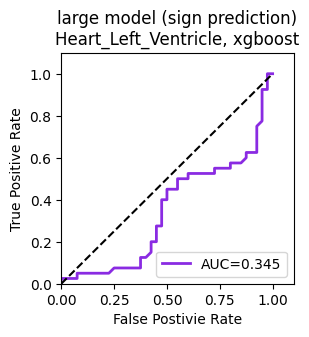

In [6]:
ml_model = model_list[0]
clf_xgb = xgb.XGBClassifier(n_estimators=n_estimators, max_depth=max_depth) # from grid search
clf_xgb.fit(X_train,Y_train)

y_score = clf_xgb.predict(X_test)                                   
y_score_pro = clf_xgb.predict_proba(X_test) 
y_one_hot = to_categorical(Y_test)
y_score_one_hot = to_categorical(y_score)

obj1 = confusion_matrix(Y_test, y_score)
print('accuracy:{}'.format(accuracy_score(Y_test, y_score)))
print('precision:{}'.format(precision_score(Y_test, y_score)))
print('recall:{}'.format(recall_score(Y_test, y_score)))
print('f1-score:{}'.format(f1_score(Y_test, y_score)))

# update confusion matrix
sum_all1 = obj1[0][0] + obj1[0][1]
sum_all2 = obj1[1][0] + obj1[1][1]
new_obj = np.array(
    [
        [float(obj1[0][0])/sum_all1, float(obj1[0][1])/sum_all1],
        [float(obj1[1][0])/sum_all2, float(obj1[1][1])/sum_all2]
    ]
)
ax = plt.subplots(figsize=(3,3))
sns.heatmap(new_obj, fmt='.2f', cmap='RdPu', annot=True)
plt.xlabel("true label")
plt.ylabel("predict label")
plt.title('large model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.savefig(image_path + 'cm-large-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
auc_ = auc(fpr, tpr)
#print("AUC : ", auc_)
ax = plt.subplots(figsize=(3,3))
plt.title('large model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.plot(fpr, tpr, linewidth = 2,label='AUC=%.3f' % auc_,color='#8A2BE2')
plt.plot([0,1],[0,1], 'k--')
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig(image_path + 'auc-large-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 2:lightgbm

In [5]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

cv_params = {'max_depth': np.linspace(1, 50, 10, dtype=int)} # 
gbm = lgb.LGBMClassifier(seed=seed,verbose=-1)
gsearch = GridSearchCV(gbm, param_grid=cv_params, cv=5, scoring='roc_auc')
gsearch.fit(X_train, Y_train)
max_depth = gsearch.best_params_['max_depth']
print(gsearch.best_params_)

cv_params = {'num_leaves': np.linspace(2, 50, 5, dtype=int)} # 
gbm = lgb.LGBMClassifier(seed=seed,max_depth=max_depth,verbose=-1)
gsearch = GridSearchCV(gbm, param_grid=cv_params, cv=5, scoring='roc_auc')
gsearch.fit(X_train, Y_train)
num_leaves = gsearch.best_params_['num_leaves']
print(gsearch.best_params_)

{'max_depth': 1}
{'num_leaves': 2}


accuracy:0.55
precision:0.46153846153846156
recall:0.75
f1-score:0.5714285714285714


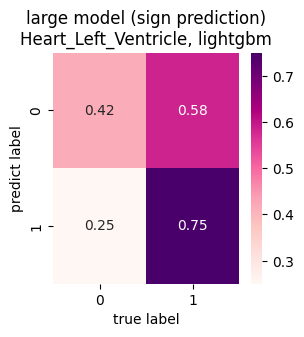

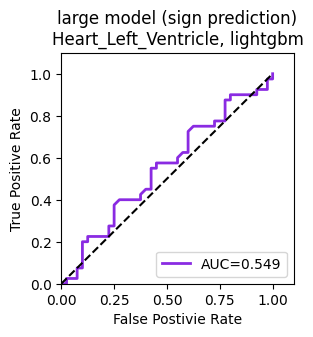

In [6]:
ml_model = model_list[1]
clf_lgb = lgb.LGBMClassifier(max_depth=max_depth, num_leaves=num_leaves)
clf_lgb.fit(X_train,Y_train)

y_score = clf_lgb.predict(X_test)                                   
y_score_pro = clf_lgb.predict_proba(X_test) 
y_one_hot = to_categorical(Y_test)
y_score_one_hot = to_categorical(y_score)

obj1 = confusion_matrix(Y_test, y_score)
print('accuracy:{}'.format(accuracy_score(Y_test, y_score)))
print('precision:{}'.format(precision_score(Y_test, y_score)))
print('recall:{}'.format(recall_score(Y_test, y_score)))
print('f1-score:{}'.format(f1_score(Y_test, y_score)))

# update confusion matrix
sum_all1 = obj1[0][0] + obj1[0][1]
sum_all2 = obj1[1][0] + obj1[1][1]
new_obj = np.array(
    [
        [float(obj1[0][0])/sum_all1, float(obj1[0][1])/sum_all1],
        [float(obj1[1][0])/sum_all2, float(obj1[1][1])/sum_all2]
    ]
)
ax = plt.subplots(figsize=(3,3))
sns.heatmap(new_obj, fmt='.2f', cmap='RdPu', annot=True)
plt.xlabel("true label")
plt.ylabel("predict label")
plt.title('large model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.savefig(image_path + 'cm-large-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
auc_ = auc(fpr, tpr)
#print("AUC : ", auc_)
ax = plt.subplots(figsize=(3,3))
plt.title('large model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.plot(fpr, tpr, linewidth = 2,label='AUC=%.3f' % auc_,color='#8A2BE2')
plt.plot([0,1],[0,1], 'k--')
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig(image_path + 'auc-large-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 3: random forest

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

cv_params = {'n_estimators': np.linspace(10, 200, 10, dtype=int)} 
rfModel = RandomForestClassifier(random_state = random.seed(seed))
grid = GridSearchCV(
    rfModel,cv_params,cv = 5,return_train_score = True, scoring='roc_auc')
grid.fit(X_train, Y_train)
n_estimators = grid.best_params_['n_estimators']
print(grid.best_params_)

cv_params = {'max_depth': np.linspace(1, 10, 10, dtype=int)} 
rfModel = RandomForestClassifier(random_state = random.seed(seed),n_estimators=n_estimators)
grid = GridSearchCV(
    rfModel,cv_params,cv = 5,return_train_score = True, scoring='roc_auc')
grid.fit(X_train, Y_train)
max_depth=grid.best_params_['max_depth']
print(grid.best_params_)

{'n_estimators': 115}
{'max_depth': 3}


accuracy:0.375
precision:0.37142857142857144
recall:0.8125
f1-score:0.5098039215686275


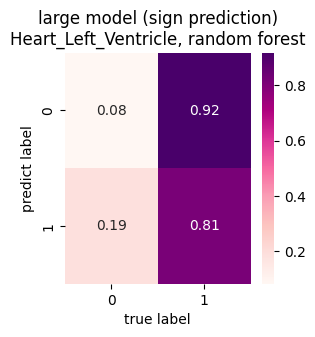

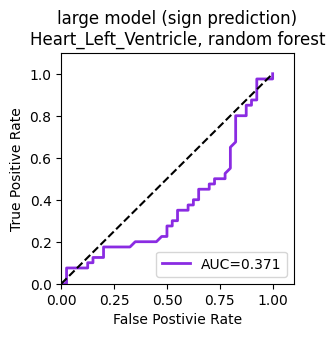

In [8]:
ml_model = model_list[2]
clf_rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth)
clf_rf.fit(X_train,Y_train)

y_score = clf_rf.predict(X_test)                                   
y_score_pro = clf_rf.predict_proba(X_test) 
y_one_hot = to_categorical(Y_test)
y_score_one_hot = to_categorical(y_score)

obj1 = confusion_matrix(Y_test, y_score)
print('accuracy:{}'.format(accuracy_score(Y_test, y_score)))
print('precision:{}'.format(precision_score(Y_test, y_score)))
print('recall:{}'.format(recall_score(Y_test, y_score)))
print('f1-score:{}'.format(f1_score(Y_test, y_score)))

# update confusion matrix
sum_all1 = obj1[0][0] + obj1[0][1]
sum_all2 = obj1[1][0] + obj1[1][1]
new_obj = np.array(
    [
        [float(obj1[0][0])/sum_all1, float(obj1[0][1])/sum_all1],
        [float(obj1[1][0])/sum_all2, float(obj1[1][1])/sum_all2]
    ]
)
ax = plt.subplots(figsize=(3,3))
sns.heatmap(new_obj, fmt='.2f', cmap='RdPu', annot=True)
plt.xlabel("true label")
plt.ylabel("predict label")
plt.title('large model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.savefig(image_path + 'cm-large-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
auc_ = auc(fpr, tpr)
#print("AUC : ", auc_)
ax = plt.subplots(figsize=(3,3))
plt.title('large model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.plot(fpr, tpr, linewidth = 2,label='AUC=%.3f' % auc_,color='#8A2BE2')
plt.plot([0,1],[0,1], 'k--')
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig(image_path + 'auc-large-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 4: knn

In [9]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

paramGride = {'n_neighbors': np.linspace(100, 300, 10, dtype=int)} 

knnModel = KNeighborsClassifier()
grid = GridSearchCV(
    knnModel,paramGride,cv = 5,return_train_score = True, scoring='roc_auc')
grid = grid.fit(X_train,Y_train)
grid.best_params_

{'n_neighbors': 122}

accuracy:0.4
precision:0.39473684210526316
recall:0.9375
f1-score:0.5555555555555556


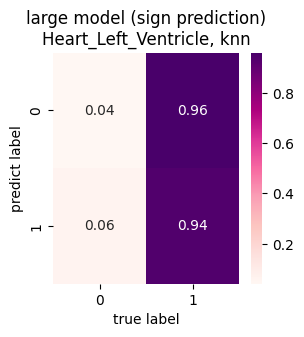

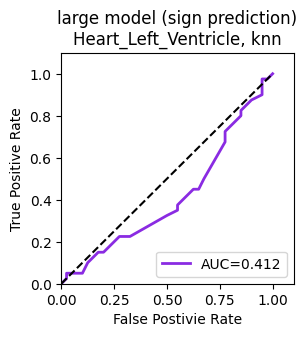

In [10]:
ml_model = model_list[3]
clf_knn = KNeighborsClassifier(n_neighbors = grid.best_params_['n_neighbors'])
clf_knn.fit(X_train,Y_train)

y_score = clf_knn.predict(X_test)                                   
y_score_pro = clf_knn.predict_proba(X_test) 
y_one_hot = to_categorical(Y_test)
y_score_one_hot = to_categorical(y_score)

obj1 = confusion_matrix(Y_test, y_score)
print('accuracy:{}'.format(accuracy_score(Y_test, y_score)))
print('precision:{}'.format(precision_score(Y_test, y_score)))
print('recall:{}'.format(recall_score(Y_test, y_score)))
print('f1-score:{}'.format(f1_score(Y_test, y_score)))

# update confusion matrix
sum_all1 = obj1[0][0] + obj1[0][1]
sum_all2 = obj1[1][0] + obj1[1][1]
new_obj = np.array(
    [
        [float(obj1[0][0])/sum_all1, float(obj1[0][1])/sum_all1],
        [float(obj1[1][0])/sum_all2, float(obj1[1][1])/sum_all2]
    ]
)
ax = plt.subplots(figsize=(3,3))
sns.heatmap(new_obj, fmt='.2f', cmap='RdPu', annot=True)
plt.xlabel("true label")
plt.ylabel("predict label")
plt.title('large model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.savefig(image_path + 'cm-large-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
auc_ = auc(fpr, tpr)
#print("AUC : ", auc_)
ax = plt.subplots(figsize=(3,3))
plt.title('large model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.plot(fpr, tpr, linewidth = 2,label='AUC=%.3f' % auc_,color='#8A2BE2')
plt.plot([0,1],[0,1], 'k--')
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig(image_path + 'auc-large-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 5: svm

In [11]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

cv_params = {'gamma': [1e-4,1e-3,1e-2,1e-1,1,10,100,1000]} 
svmModel = SVC()
grid = GridSearchCV(
    svmModel,cv_params,cv = 5,return_train_score = True, scoring='roc_auc')
grid = grid.fit(X_train,Y_train)
gamma = grid.best_params_['gamma']
print(grid.best_params_)

cv_params = {'C': [1e-4,1e-3,1e-2,1e-1,1,10,100,1000]} 
svmModel = SVC(gamma=gamma)
grid = GridSearchCV(
    svmModel,cv_params,cv = 5,return_train_score = True, scoring='roc_auc')
grid = grid.fit(X_train,Y_train)
C = grid.best_params_['C']
print(grid.best_params_)

{'gamma': 1}
{'C': 1}


accuracy:0.4
precision:0.4
recall:1.0
f1-score:0.5714285714285715


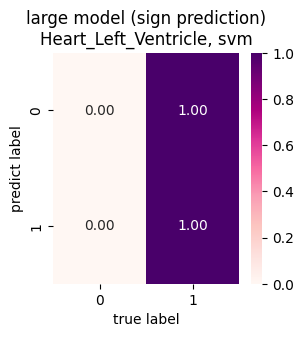

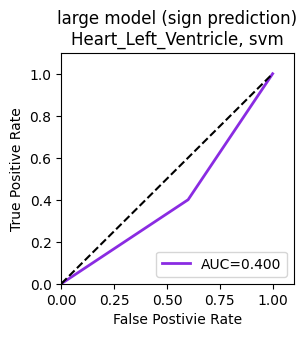

In [12]:
ml_model = model_list[4]
clf_svm = SVC(probability = True, gamma = gamma, C = C)
clf_svm.fit(X_train,Y_train)

y_score = clf_svm.predict(X_test)                                   
y_score_pro = clf_svm.predict_proba(X_test) 
y_one_hot = to_categorical(Y_test)
y_score_one_hot = to_categorical(y_score)

obj1 = confusion_matrix(Y_test, y_score)
print('accuracy:{}'.format(accuracy_score(Y_test, y_score)))
print('precision:{}'.format(precision_score(Y_test, y_score)))
print('recall:{}'.format(recall_score(Y_test, y_score)))
print('f1-score:{}'.format(f1_score(Y_test, y_score)))

# update confusion matrix
sum_all1 = obj1[0][0] + obj1[0][1]
sum_all2 = obj1[1][0] + obj1[1][1]
new_obj = np.array(
    [
        [float(obj1[0][0])/sum_all1, float(obj1[0][1])/sum_all1],
        [float(obj1[1][0])/sum_all2, float(obj1[1][1])/sum_all2]
    ]
)
ax = plt.subplots(figsize=(3,3))
sns.heatmap(new_obj, fmt='.2f', cmap='RdPu', annot=True)
plt.xlabel("true label")
plt.ylabel("predict label")
plt.title('large model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.savefig(image_path + 'cm-large-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
auc_ = auc(fpr, tpr)
#print("AUC : ", auc_)
ax = plt.subplots(figsize=(3,3))
plt.title('large model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.plot(fpr, tpr, linewidth = 2,label='AUC=%.3f' % auc_,color='#8A2BE2')
plt.plot([0,1],[0,1], 'k--')
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig(image_path + 'auc-large-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()